## 사용할 패키지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import datetime

## 데이터 불러오기

In [2]:
energy = pd.read_csv('energy.csv')
dangjin_fcst = pd.read_csv('dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('ulsan_fcst_data.csv')

In [3]:
energy.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2018-03-01 1:00:00,0.0,0.0,0,0
1,2018-03-01 2:00:00,0.0,0.0,0,0
2,2018-03-01 3:00:00,0.0,0.0,0,0
3,2018-03-01 4:00:00,0.0,0.0,0,0
4,2018-03-01 5:00:00,0.0,0.0,0,0


In [4]:
dangjin_fcst.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0


In [5]:
ulsan_fcst.head()

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,8.0,20.0,14.0,298.0,2.0
1,2018-03-01 11:00:00,7.0,4.0,20.0,4.3,298.0,2.0
2,2018-03-01 11:00:00,10.0,3.0,30.0,1.9,309.0,2.0
3,2018-03-01 11:00:00,13.0,0.0,40.0,1.5,318.0,2.0
4,2018-03-01 11:00:00,16.0,-1.0,45.0,1.8,308.0,2.0


기상 예보는 전날 14시(오후 2시) 예보를 선형보간하여 사용하였습니다.

※ 기상 예보 전치리 과정 : https://dacon.io/competitions/official/235720/codeshare/2499?page=1&dtype=recent

In [6]:
dangjin_fcst['Forecast_time'] = pd.to_datetime(dangjin_fcst['Forecast time'])
ulsan_fcst['Forecast_time'] = pd.to_datetime(ulsan_fcst['Forecast time'])

In [7]:
dangjin_fcst_14 = dangjin_fcst[dangjin_fcst['Forecast_time'].dt.hour==14]
ulsan_fcst_14 = ulsan_fcst[ulsan_fcst['Forecast_time'].dt.hour==14]

In [8]:
dangjin_fcst_14 = dangjin_fcst_14[(dangjin_fcst_14['forecast']>=10)&(dangjin_fcst_14['forecast']<=33)]
ulsan_fcst_14 = ulsan_fcst_14[(ulsan_fcst_14['forecast']>=10)&(ulsan_fcst_14['forecast']<=33)]

In [9]:
def to_date(x):
    return pd.DateOffset(hours=x)

dangjin_fcst_14['Forecast_time'] = dangjin_fcst_14['Forecast_time'] + dangjin_fcst_14['forecast'].map(to_date)
ulsan_fcst_14['Forecast_time'] = ulsan_fcst_14['Forecast_time'] + ulsan_fcst_14['forecast'].map(to_date)

C:\Users\ratsa\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\arrays\datetimelike.py:1111: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


In [10]:
dangjin_fcst_14 = dangjin_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
ulsan_fcst_14 = ulsan_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

In [11]:
dangjin_fcst_14_ = pd.DataFrame()
dangjin_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

ulsan_fcst_14_ = pd.DataFrame()
ulsan_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

In [12]:
dangjin_fcst_14_ = pd.merge(dangjin_fcst_14_, dangjin_fcst_14, on='Forecast_time', how='outer')
ulsan_fcst_14_ = pd.merge(ulsan_fcst_14_, ulsan_fcst_14, on='Forecast_time', how='outer')

In [13]:
dangjin_fcst = dangjin_fcst_14_.interpolate()
ulsan_fcst = ulsan_fcst_14_.interpolate()

In [14]:
dangjin_fcst['Forecast_time'] = dangjin_fcst['Forecast_time'].astype(str)
ulsan_fcst['Forecast_time'] = ulsan_fcst['Forecast_time'].astype(str)

In [15]:
def transform_wind_to_vector(df_):
    df = df_.copy()

    wv = df['WindSpeed']

    # Convert to radians.
    wd_rad = df['WindDirection']*np.pi / 180

    # Calculate the wind x and y components.
    df['Wind_X'] = wv*np.cos(wd_rad)
    df['Wind_Y'] = wv*np.sin(wd_rad)
    
    return df

In [16]:
def transform_datetime_to_signal(df_):
    df = df_.copy()
    date_time = pd.to_datetime(df['Forecast_time'], format='%Y.%m.%d %H:%M')
    timestamp_s = date_time.map(datetime.datetime.timestamp)

    day = 24*60*60
    year = (365.2425)*day

    df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    return df

In [17]:
dangjin_fcst = transform_wind_to_vector(dangjin_fcst)
dangjin_fcst = transform_datetime_to_signal(dangjin_fcst)

In [18]:
dangjin_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,-2.000000,55.000000,6.7,336.000000,1.0,6.120755,-2.725136,-0.707107,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,-2.666667,55.000000,6.3,337.000000,1.0,5.799181,-2.461606,-0.866025,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,-3.333333,55.000000,5.9,338.000000,1.0,5.470385,-2.210179,-0.965926,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,-4.000000,55.000000,5.5,339.000000,1.0,5.134692,-1.971024,-1.000000,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,-4.333333,56.666667,5.1,340.666667,1.0,4.812403,-1.688423,-0.965926,2.588190e-01,0.859748,0.510719


In [19]:
ulsan_fcst = transform_wind_to_vector(ulsan_fcst)
ulsan_fcst = transform_datetime_to_signal(ulsan_fcst)

In [20]:
ulsan_fcst.head()

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Wind_X,Wind_Y,Day sin,Day cos,Year sin,Year cos
0,2018-03-02 00:00:00,0.000000,40.000000,1.500000,318.000000,2.000000,1.114717,-1.003696,-0.707107,-7.071068e-01,0.858280,0.513182
1,2018-03-02 01:00:00,-0.333333,41.666667,1.600000,314.666667,2.000000,1.124770,-1.137934,-0.866025,-5.000000e-01,0.858648,0.512566
2,2018-03-02 02:00:00,-0.666667,43.333333,1.700000,311.333333,2.000000,1.122746,-1.276496,-0.965926,-2.588190e-01,0.859015,0.511951
3,2018-03-02 03:00:00,-1.000000,45.000000,1.800000,308.000000,2.000000,1.108191,-1.418419,-1.000000,-3.848660e-12,0.859382,0.511335
4,2018-03-02 04:00:00,-1.333333,45.000000,1.766667,303.333333,1.666667,0.970799,-1.476028,-0.965926,2.588190e-01,0.859748,0.510719


## 학습 데이터 전처리

In [21]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    # feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    feature_df = concat_df[[#'year', 'month', 'day', 'hour', 
                            'Year sin', 'Year cos', 'Day sin', 'Day cos',
                            'Temperature', 'Humidity', 
                            #'WindSpeed', 'WindDirection',
                            'Wind_X', 'Wind_Y', 
                            'Cloud', target]]
    
    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    #train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_x = train_df.loc[:, :'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    #val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_x = val_df.loc[:, :'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

## LightGBM Custom Metric

In [22]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

## Validation Metric

In [23]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

## LightGBM Hyperparameter

In [24]:
params = {
    'learning_rate': 0.01,
    'num_iterations': 1000,
    'max_depth': 16,
    #'boosting': 'rf',
    #'feature_fraction': 0.8,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

### 당진수상태양광 예측 모델 학습

In [25]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_floating')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_floating_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

C:\Users\ratsa\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1712
[LightGBM] [Info] Number of data points in the train set: 12378, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 247.345048
Tra

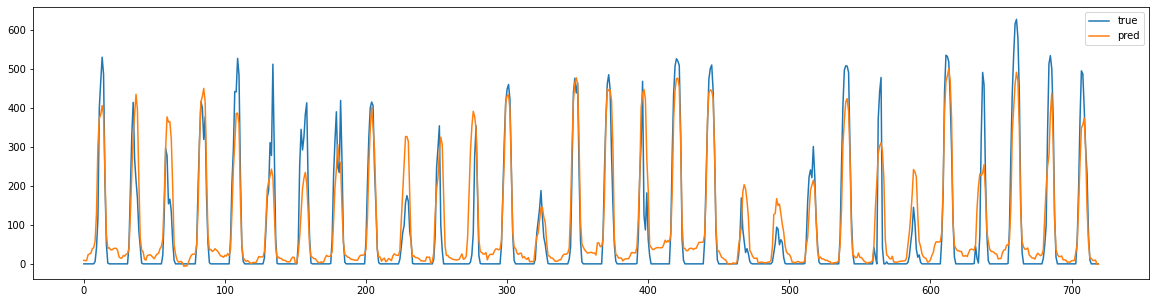

CV Score :  8.08268535467398


In [26]:
pred = dangjin_floating_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 당진자재창고태양광 예측 모델 학습

In [27]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin_warehouse')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 700
dangjin_warehouse_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

C:\Users\ratsa\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1712
[LightGBM] [Info] Number of data points in the train set: 11949, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 193.765671
Tra

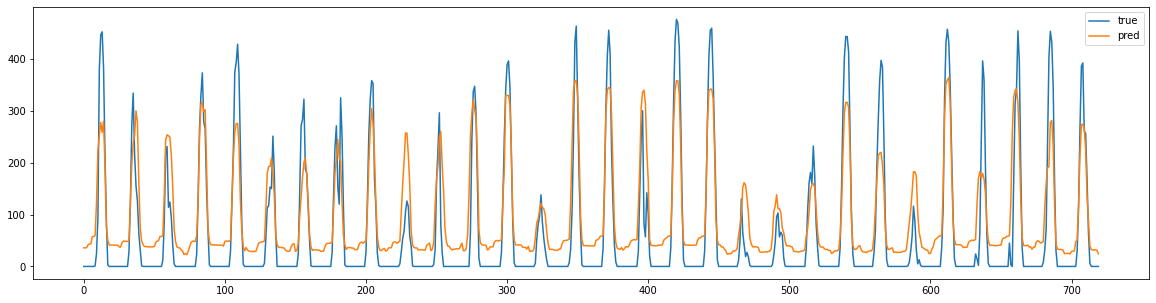

CV Score :  9.77786316484443


In [28]:
pred = dangjin_warehouse_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 당진태양광 예측 모델 학습

In [29]:
train_x, train_y, val_x, val_y = train_datast(energy, dangjin_fcst, target='dangjin')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 1000
dangjin_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

C:\Users\ratsa\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1712
[LightGBM] [Info] Number of data points in the train set: 11349, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 308.414486
Tra

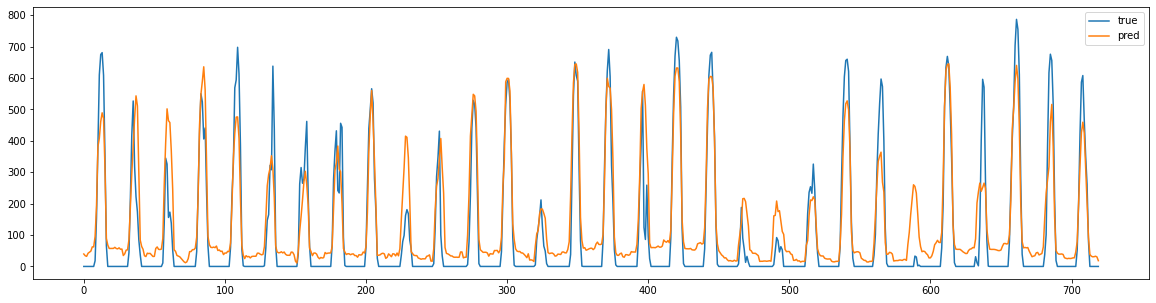

CV Score :  9.89379274004656


In [30]:
pred = dangjin_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

### 울산태양광 예측 모델 학습

In [31]:
train_x, train_y, val_x, val_y = train_datast(energy, ulsan_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

C:\Users\ratsa\AppData\Local\Programs\Python\Python37\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 135.559394
Tra

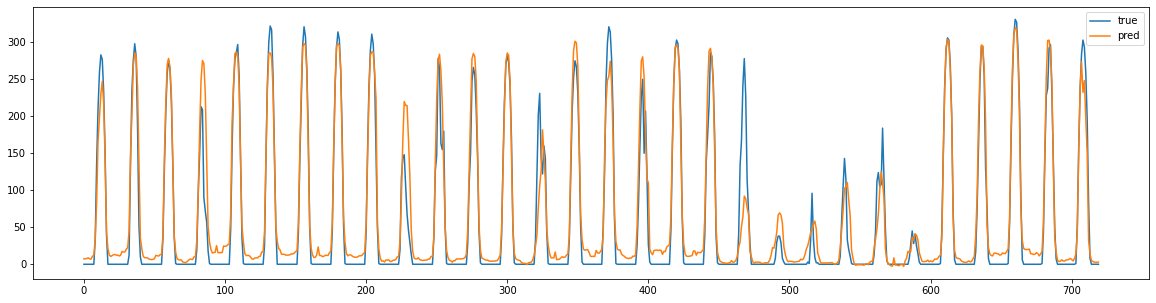

CV Score :  5.905086180276545


In [32]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

## 테스트 데이터 전처리

In [33]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    #test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    test_df = test_df[[#'year', 'month', 'day', 'hour', 
                        'Year sin', 'Year cos', 'Day sin', 'Day cos',
                        'Temperature', 'Humidity', 
                        #'WindSpeed', 'WindDirection',
                        'Wind_X', 'Wind_Y', 
                        'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [34]:
dangjin_test = test_datast(dangjin_fcst)
ulsan_test = test_datast(ulsan_fcst)

## 각 발전소 발전량 추론

In [35]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

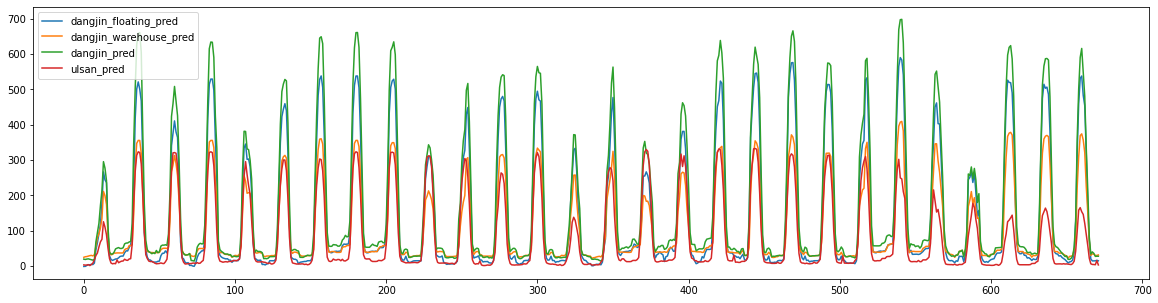

In [36]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

## 제출

In [37]:
submission = pd.read_csv('sample_submission.csv')

In [38]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [39]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,-0.867556,25.003493,19.843368,3.457792
1,2021-02-01 02:00:00,-0.652633,26.603083,18.873031,2.871624
2,2021-02-01 03:00:00,1.877236,27.139748,20.006091,3.145435
3,2021-02-01 04:00:00,3.914076,28.536064,20.597042,4.349568
4,2021-02-01 05:00:00,3.871114,29.686464,19.292760,1.607398
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [40]:
submission.to_csv('dacon_baseline_wind_time.csv', index=False)